In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

import ABC_train_test3
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean, variance , stdev
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# Read the dataset 
df = pd.read_csv('quadratic_constant_variance_dataset.csv')
df = df.iloc[: , 1:]
df.head()

,X0,X1,X2,X3,X4,Y
0,0.007532,0.726126,0.129670,0.583629,0.616938,-0.876501
1,0.048824,0.691019,0.101017,0.255914,0.580179,-1.824287
2,0.950579,0.719599,0.371026,0.686286,0.425361,-1.466412
3,0.212880,0.169486,0.031770,0.070160,0.361210,0.145944
4,0.571757,0.109421,0.656061,0.473611,0.843452,1.242280


In [3]:
n_features = 5

# Get X and Y
X = df.iloc[:,0:n_features]
Y = df.iloc[:,n_features]

#Add Constant 
X = X.to_numpy()
Y = Y.to_numpy()

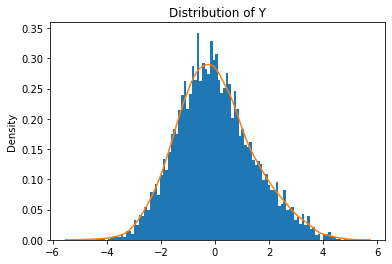

In [4]:
plt.hist(Y,bins=100,density=True)
sns.distplot(Y,hist=False)
plt.title("Distribution of Y")
plt.show()

In [5]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

In [6]:
# Training Parameters 
n_epochs = 5000
batch_size = 64
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Prior Model MAE 0.9506310679769675


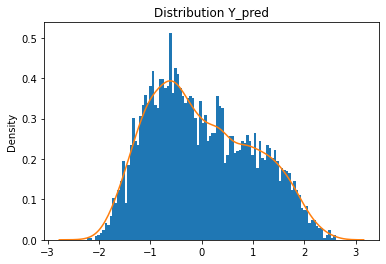

In [7]:
# Fit the prior model and pre - generator 
variance = 1 # Constant Variance 

# Exact Prior Model
y_pred = ABC_train_test3.quadratic_model(X)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Prior Model MAE : Error in data",mae)
print("Prior Model MAE", mae)

plt.hist(y_pred,bins=100,density=True)
sns.distplot(y_pred,hist=False)
plt.title("Distribution Y_pred")
plt.show()

##  mGAN 

In [8]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [9]:
#Training the ABC_GAN 
ABC_train_test3.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

KeyboardInterrupt: 

In [ ]:
ABC_GAN1_metrics=ABC_train_test3.test_generator(gen,test_data,ABC_train_test3.linear_model,variance,"1",device)
# sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

In [ ]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [ ]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


In [ ]:
ABC_train_test3.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [ ]:
ABC_GAN3_metrics=ABC_train_test3.test_generator(gen3,test_data,ABC_train_test3.linear_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

In [ ]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [ ]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())